# BUS 41204 Machine Learning
## Winter 2023 Midterm

### Yazmin Ramirez Delgado
#### yazramirez@uchicago.edu

# 1 Question [30 points]

The file eBayAuctions.csv contains information on 1972 auctions transacted on eBay.com during May–June 2004. The goal is to use these data to build a model that will distinguish competitive auctions from noncompetitive ones. A competitive auction is defined as an auction with at least two bids placed on the item being auctioned. The data include variables that describe the item (auction category), the seller (his or her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day of week of auction close). In addition, we have the price at which the auction closed. The goal is to predict whether or not an auction of interest will be competitive.

Partition the data into training (60%) and validation (40%) set.

1. Discuss if you can use all the variables to predict at the start of an auction whether it will be competitive.
2. Build a classification tree, a boosted tree, a bagged tree, and a random forest model (with mtry = 4). Choose the tuning parameters for these models by optimizing the performance on the validation set. Report accuracies of these four models as well as their confusion matrices on the validation set.
3. Create lift curves for these four models. What is the lift for the top 10% of observations in the validation set?
4. Briefly describe how boosted tree, bagged tree and random forest models are conceptually similar and how are they conceptually different.

In [2]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
%matplotlib inline

import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score,precision_score
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb

# Import necessary libraries
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

First, let read the csv we are going to work on and run the information of the data to have a general idea of the information we are going to work with.

In [3]:
auctions = pd.read_csv('eBayAuctions.csv')
# To handle better the data let's convert the columns to upper case
auctions.columns = auctions.columns.str.upper()
auctions

,CATEGORY,CURRENCY,SELLERRATING,DURATION,ENDDAY,CLOSEPRICE,OPENPRICE,COMPETITIVE?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,Automotive,US,2992,5,Sun,359.95,359.95,0
1968,Automotive,US,21,5,Sat,610.00,300.00,1
1969,Automotive,US,1400,5,Mon,549.00,549.00,0
1970,Automotive,US,57,7,Fri,820.00,650.00,1


In [4]:
auctions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CATEGORY      1972 non-null   object 
 1   CURRENCY      1972 non-null   object 
 2   SELLERRATING  1972 non-null   int64  
 3   DURATION      1972 non-null   int64  
 4   ENDDAY        1972 non-null   object 
 5   CLOSEPRICE    1972 non-null   float64
 6   OPENPRICE     1972 non-null   float64
 7   COMPETITIVE?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [5]:
print(auctions.describe())

       SELLERRATING     DURATION   CLOSEPRICE    OPENPRICE  COMPETITIVE?
count   1972.000000  1972.000000  1972.000000  1972.000000   1972.000000
mean    3560.238337     6.486308    36.449087    12.926268      0.540568
std     5973.011033     2.052906    89.493858    38.856149      0.498478
min        0.000000     1.000000     0.010000     0.010000      0.000000
25%      595.000000     5.000000     4.907500     1.230000      0.000000
50%     1853.000000     7.000000     9.995000     4.500000      1.000000
75%     3380.000000     7.000000    28.000000     9.990000      1.000000
max    37727.000000    10.000000   999.000000   999.000000      1.000000


From the information we can see that we have 1972 observations and 8 variables. We have 3 variables that are categorical and 4 variables that are numerical and 1 binary variable.

In [6]:
auctions['COMPETITIVE?'].value_counts()

1    1066
0     906
Name: COMPETITIVE?, dtype: int64

In [7]:
# Count the number of rows that have competitive as 1 but openprice and closeprice are equal
auctions[(auctions['COMPETITIVE?'] == 1) & (auctions['OPENPRICE'] == auctions['CLOSEPRICE'])].shape[0]

38

Since having rows marked as competitive, but their open price and close price are the same, we are going to remove those rows.

In [8]:
# Remove the rows that have competitive as 1 but openprice and closeprice are equal
auctions = auctions[~((auctions['COMPETITIVE?'] == 1) & (auctions['OPENPRICE'] == auctions['CLOSEPRICE']))]
auctions.shape

(1934, 8)

As a next step, we already mentioned that we have 3 categorical variables, so we are going to create dummy variables for them.

In [9]:
# Creates dummy variables for the categorical variables: Category, Currency and endDay
auctions = pd.get_dummies(auctions, columns=['CATEGORY', 'CURRENCY', 'ENDDAY'])
auctions.shape

(1934, 33)

To decide whether we can use all the variables to predict at the start of an auction whether it will be competitive, we are going to select the most important variables using the Random Forest feature importance method

In [10]:
# Data summary
print(auctions.describe())

       SELLERRATING     DURATION   CLOSEPRICE    OPENPRICE  COMPETITIVE?  \
count    1934.00000  1934.000000  1934.000000  1934.000000   1934.000000   
mean     3577.07394     6.490693    36.936262    12.951256      0.531541   
std      6008.67822     2.047968    90.260661    39.142807      0.499133   
min         0.00000     1.000000     0.010000     0.010000      0.000000   
25%       595.00000     5.000000     4.950000     1.230000      0.000000   
50%      1853.00000     7.000000    10.490000     4.855000      1.000000   
75%      3380.00000     7.000000    28.370000     9.990000      1.000000   
max     37727.00000    10.000000   999.000000   999.000000      1.000000   

       CATEGORY_Antique/Art/Craft  CATEGORY_Automotive  CATEGORY_Books  \
count                 1934.000000          1934.000000     1934.000000   
mean                     0.088418             0.089969        0.026887   
std                      0.283975             0.286211        0.161796   
min                

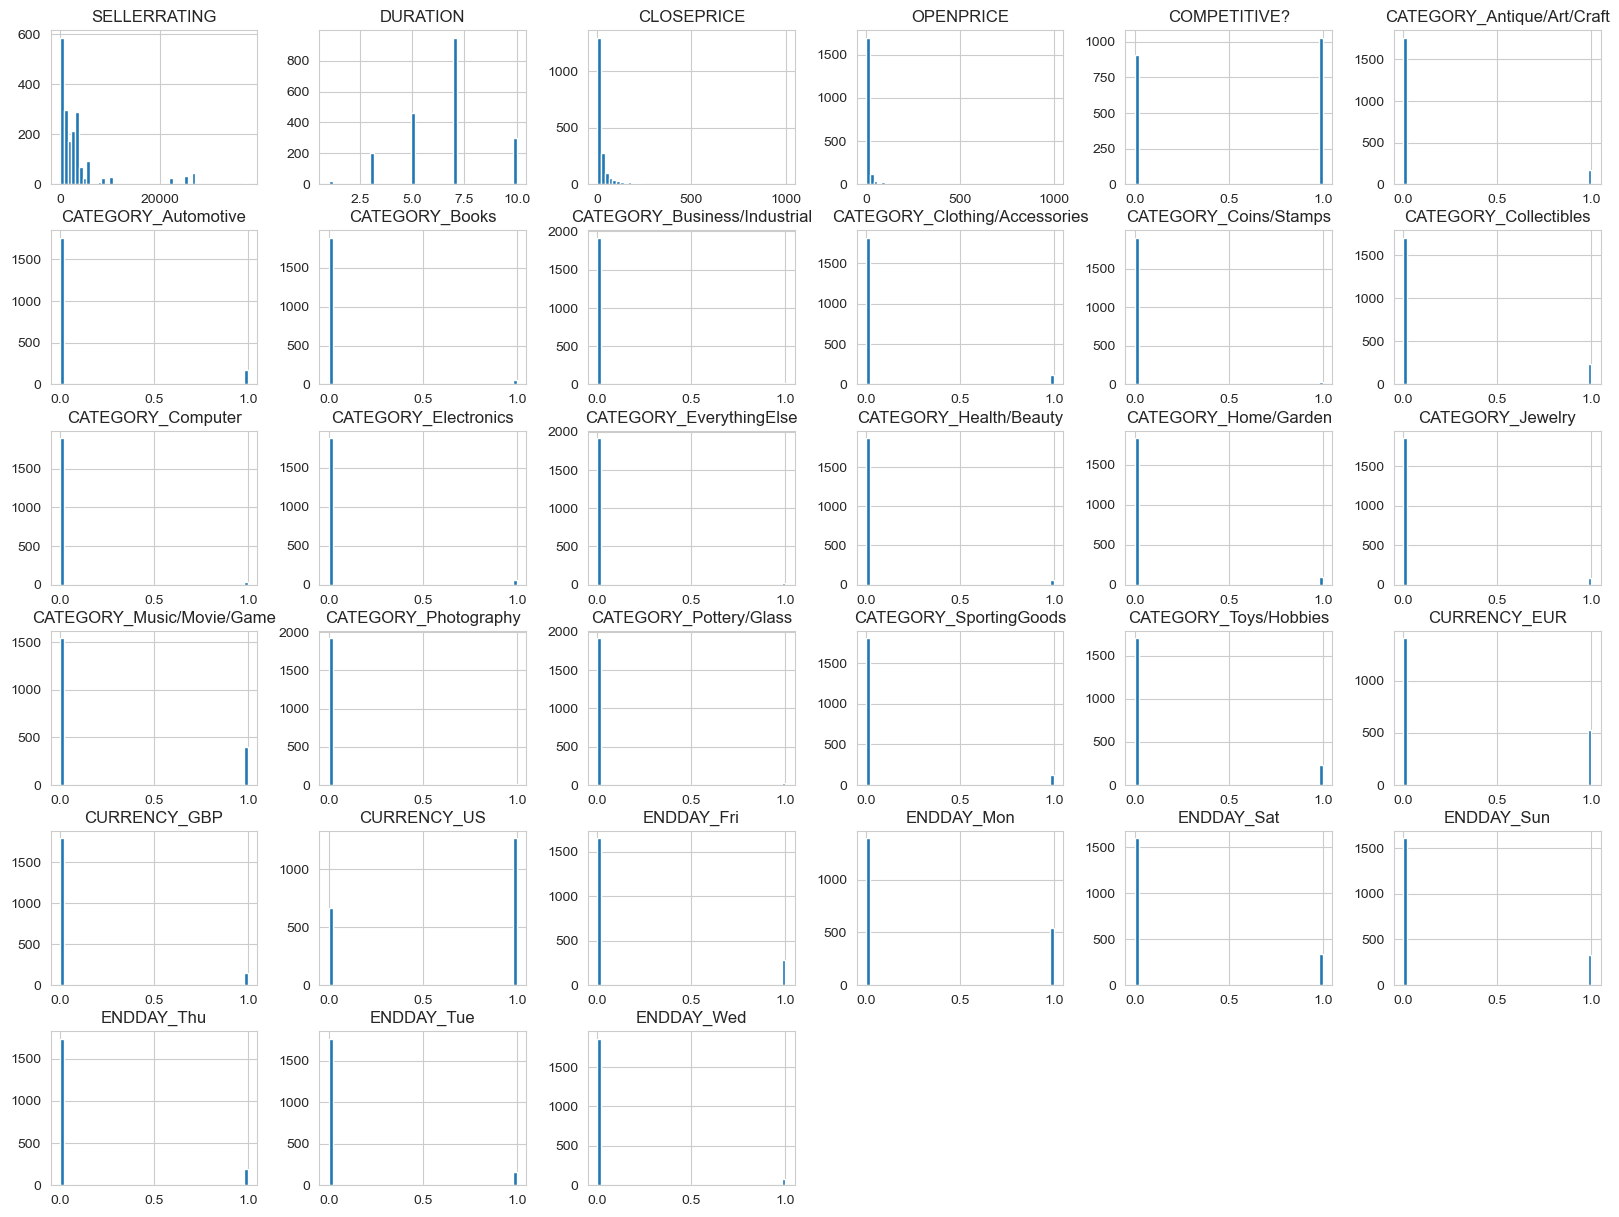

In [11]:
# Data distribution
auctions.hist(bins=50, figsize=(20,15))
plt.show()

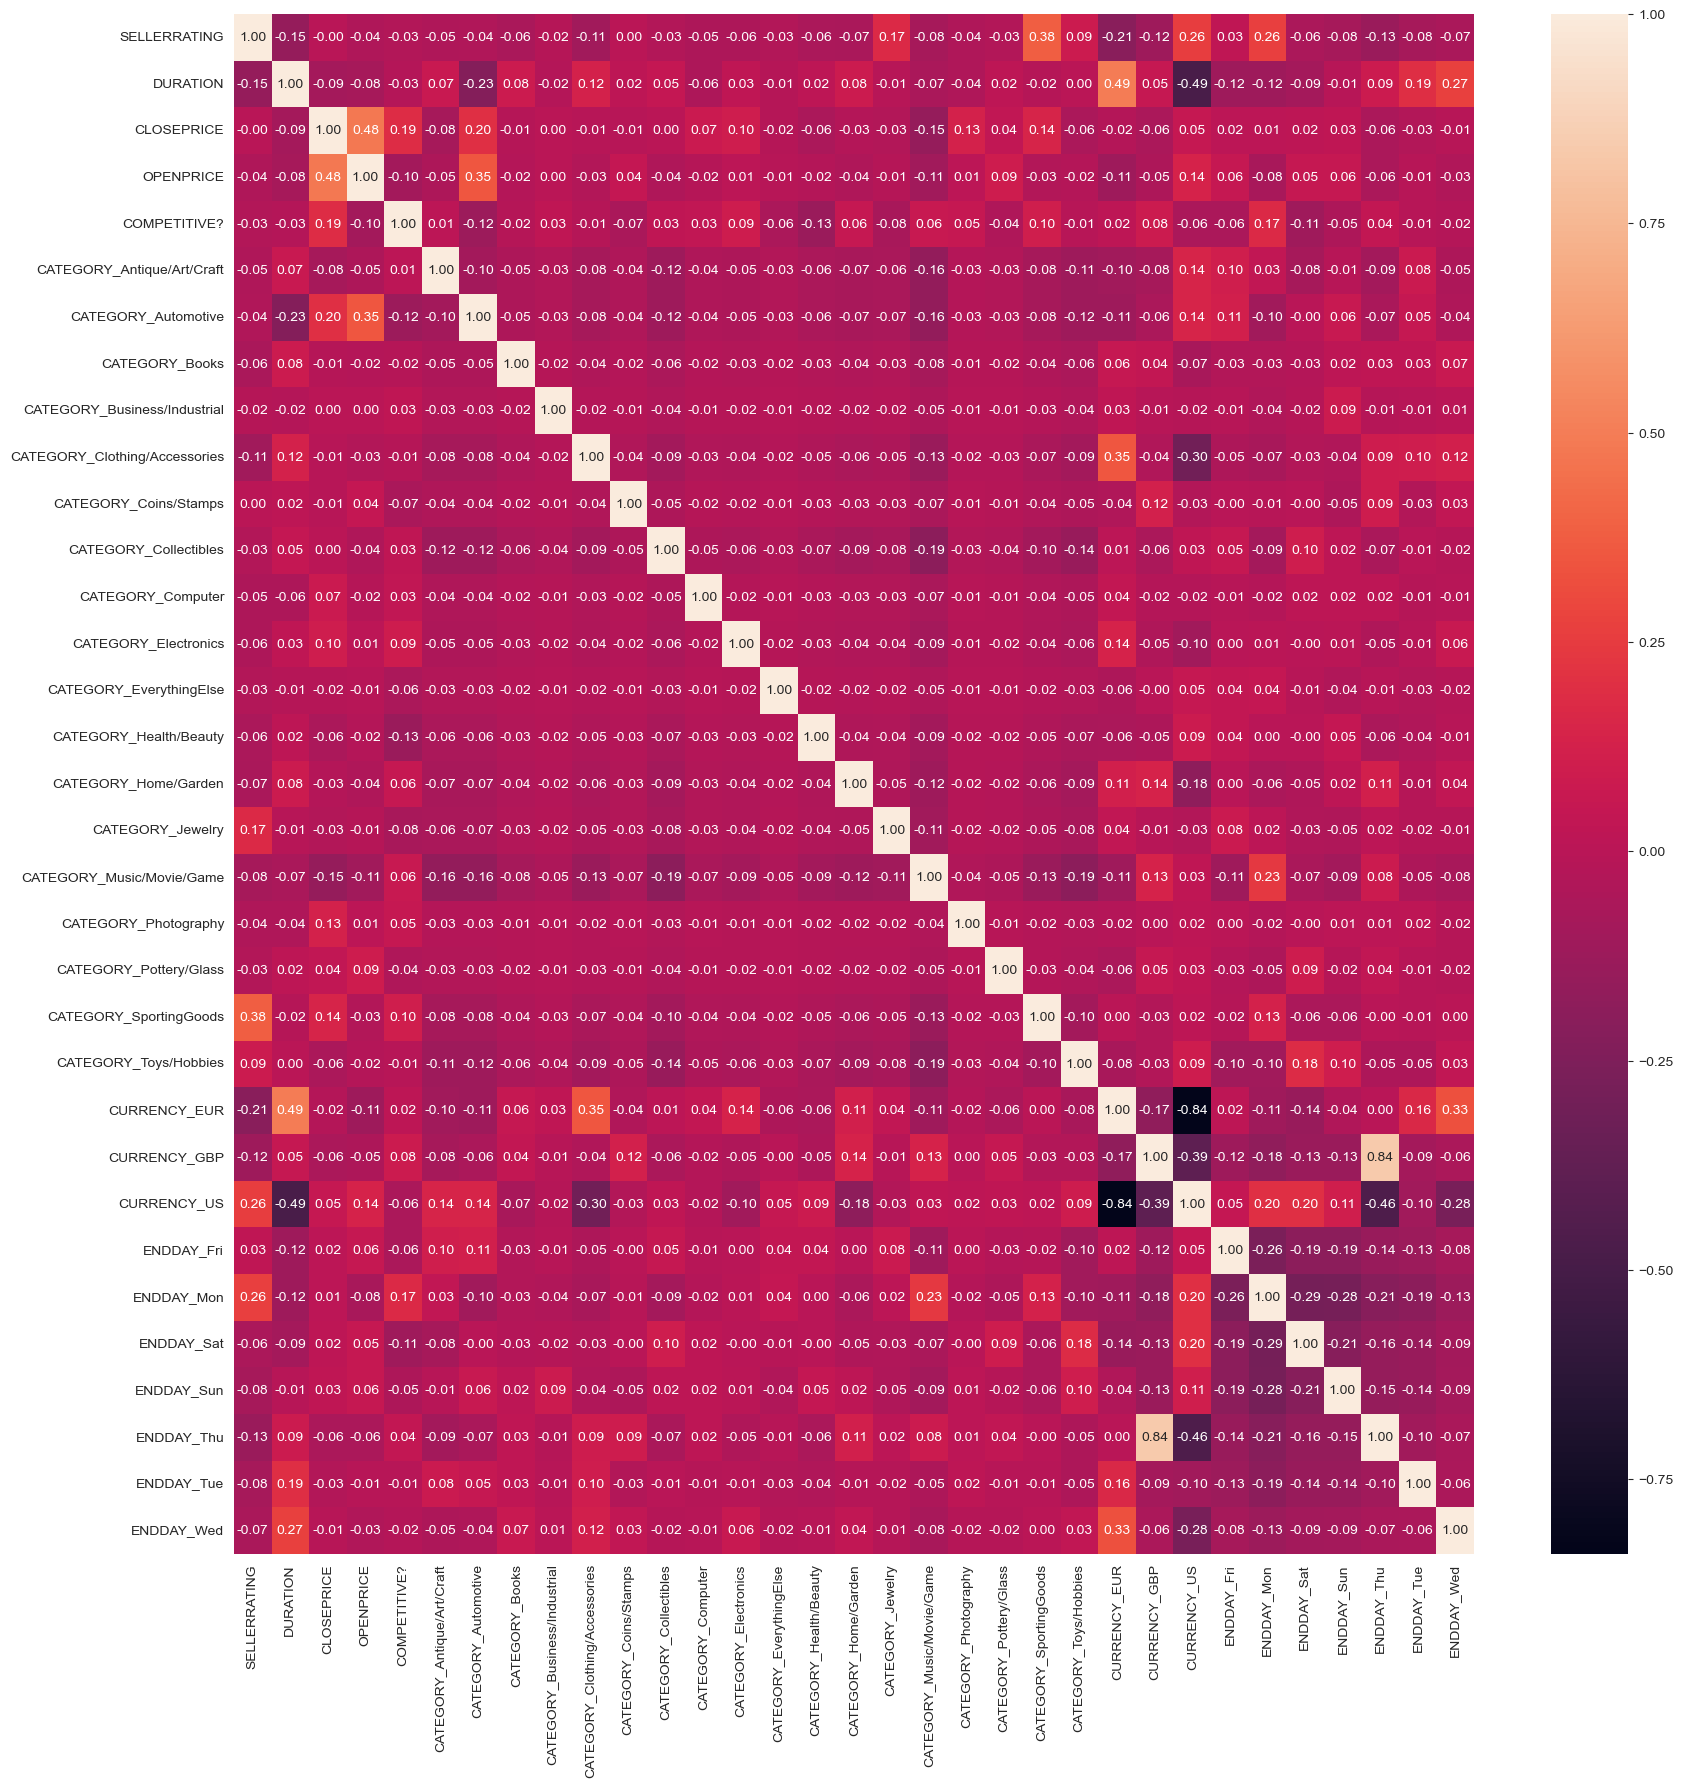

In [12]:
# Correlation analysis between the variables with a heatmap
import seaborn as sns
corr = auctions.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [14]:
# Feature importance using Random Forest
X = auctions.drop('COMPETITIVE?', axis=1)
y = auctions['COMPETITIVE?']
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf.fit(X, y)
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
CLOSEPRICE,0.376225
OPENPRICE,0.256920
SELLERRATING,0.121897
DURATION,0.033067
ENDDAY_Mon,0.016200
CATEGORY_Music/Movie/Game,0.013232
CATEGORY_Automotive,0.012145
CURRENCY_EUR,0.011780
CURRENCY_US,0.010855
ENDDAY_Sat,0.010570


### 1.1

Based on the feature selection results, it appears that the CLOSEPRICE variable has the highest feature importance, with a value of 0.3748. However, it is important to note that this variable cannot be used to predict whether an auction will be competitive, as it represents the price at which the auction closed, which is not known at the start of the auction.

Therefore, we should focus on the other variables in the dataset, such as OPENPRICE, SELLERRATING, DURATION, and the various categorical and binary variables related to the auction category, currency, and day of the week. These variables can be used to build a model that predicts whether an auction will be competitive at the start of the auction, which is the ultimate goal of the analysis.

Now, let's move to the next step, which is to build the models.

### 1.2

In [15]:
# Remove CLOSE PRICE from X 
X = X.drop('CLOSEPRICE', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=410)
# Print the shapes of the resulting datasets
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)

Training set shape:  (1160, 31)
Validation set shape:  (774, 31)


In [17]:
xgb_model = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, alpha = 10)
kf = KFold(n_splits=5)
param_grid = {'max_depth': [3,4,5],'n_estimators': [100,200,300],'learning_rate': [0.1,0.2,0.3]}
xgb_grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, verbose=0)
xgb_grid_search.fit(X_train, y_train)
xgb_model = xgb_grid_search.best_estimator_
print("Best hyperparameters for XGBoost: ", xgb_grid_search.best_params_)

Best hyperparameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [18]:
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
# Convert predictions to binary
xgb_pred = np.where(xgb_pred > 0.5, 1, 0)
xgb_acc = accuracy_score(y_val, xgb_pred)
xgb_cm = confusion_matrix(y_val, xgb_pred)
print("Accuracy for XGBoost: ", xgb_acc)
print("Confusion Matrix for XGBoost: ", xgb_cm)

Accuracy for XGBoost:  0.7351421188630491
Confusion Matrix for XGBoost:  [[250 114]
 [ 91 319]]


In [19]:
from sklearn.model_selection import GridSearchCV

# Build a classification tree and optimize its hyperparameters
dt = DecisionTreeClassifier(random_state=410)
param_grid = {'max_depth': [18,20,24,28,35], 'min_samples_leaf': [2, 4, 8, 10], 'min_samples_split': [2, 4, 8, 12]}
grid_dt = GridSearchCV(dt, param_grid, cv=5)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

print('Best parameters for Classification Tree:', grid_dt.best_params_)

# Build a bagged tree and optimize its hyperparameters
bagging = BaggingClassifier(base_estimator=best_dt, random_state=410)
param_grid = {'max_samples': [0.5, 0.7, 0.9, 1.0], 'max_features': [0.5, 0.7, 0.9, 1.0], 'n_estimators': [50, 100, 200, 300]}
grid_bagging = GridSearchCV(bagging, param_grid, cv=5)
grid_bagging.fit(X_train, y_train)
best_bagging = grid_bagging.best_estimator_

print('Best parameters for Bagged Tree:', grid_bagging.best_params_)

# Build a random forest and optimize its hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_features=4, random_state=410)
param_grid = {'max_depth': [ 6, 8, 10,12,14,16], 'min_samples_leaf': [2, 4, 8]}
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print('Best parameters for Random Forest:', grid_rf.best_params_)

# Build a boosted tree and optimize its hyperparameters
boosting = AdaBoostClassifier(base_estimator=best_dt, random_state=410)
param_grid = {'learning_rate': [.7, 1, 1.2], 'n_estimators': [200, 300,400]}
grid_boosting = GridSearchCV(boosting, param_grid, cv=5)
grid_boosting.fit(X_train, y_train)
best_boosting = grid_boosting.best_estimator_

print('Best parameters for Boosted Tree:', grid_boosting.best_params_)


Best parameters for Classification Tree: {'max_depth': 18, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best parameters for Bagged Tree: {'max_features': 0.9, 'max_samples': 1.0, 'n_estimators': 200}
Best parameters for Random Forest: {'max_depth': 14, 'min_samples_leaf': 2}
Best parameters for Boosted Tree: {'learning_rate': 1.2, 'n_estimators': 200}
Classification Tree Accuracy: 0.7183
Bagged Tree Accuracy: 0.7506
Random Forest Accuracy: 0.7558
Boosted Tree Accuracy: 0.7158


In [20]:
# Evaluate the models on the validation set
models = {'Classification Tree': best_dt, 'Bagged Tree': best_bagging, 'Random Forest': best_rf, 'Boosted Tree': best_boosting}
for name, model in models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(f'{name} Confusion Matrix: {cm}')

Classification Tree Accuracy: 0.7183
Classification Tree Confusion Matrix: [[241 123]
 [ 95 315]]
Bagged Tree Accuracy: 0.7506
Bagged Tree Confusion Matrix: [[258 106]
 [ 87 323]]
Random Forest Accuracy: 0.7558
Random Forest Confusion Matrix: [[267  97]
 [ 92 318]]
Boosted Tree Accuracy: 0.7158
Boosted Tree Confusion Matrix: [[234 130]
 [ 90 320]]


### 1.3

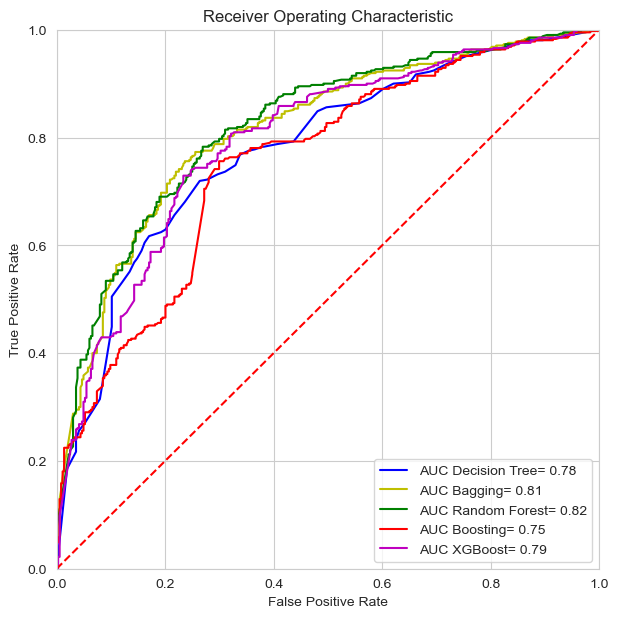

In [23]:
pred_tree = best_dt.predict_proba(X_val)
pred_bagging = best_bagging.predict_proba(X_val)
pred_rf = best_rf.predict_proba(X_val)
pred_boosting = best_boosting.predict_proba(X_val)
pred_xgb = xgb_model.predict_proba(X_val)

# Plot AUC-ROC
fpr_tree, tpr_tree, threshold_tree = roc_curve(y_val, pred_tree[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)
fpr_bagging, tpr_bagging, threshold_bagging = roc_curve(y_val, pred_bagging[:,1])
roc_auc_bagging = auc(fpr_bagging, tpr_bagging)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_val, pred_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_boosting, tpr_boosting, threshold_boosting = roc_curve(y_val, pred_boosting[:,1])
roc_auc_boosting = auc(fpr_boosting, tpr_boosting)
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_val, pred_xgb[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC Decision Tree= %0.2f' % roc_auc_tree)
plt.plot(fpr_bagging, tpr_bagging, 'y', label = 'AUC Bagging= %0.2f' % roc_auc_bagging)
plt.plot(fpr_rf, tpr_rf, 'g', label = 'AUC Random Forest= %0.2f' % roc_auc_rf)
plt.plot(fpr_boosting, tpr_boosting, 'r', label = 'AUC Boosting= %0.2f' % roc_auc_boosting)
plt.plot(fpr_xgb, tpr_xgb, 'm', label = 'AUC XGBoost= %0.2f' % roc_auc_xgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

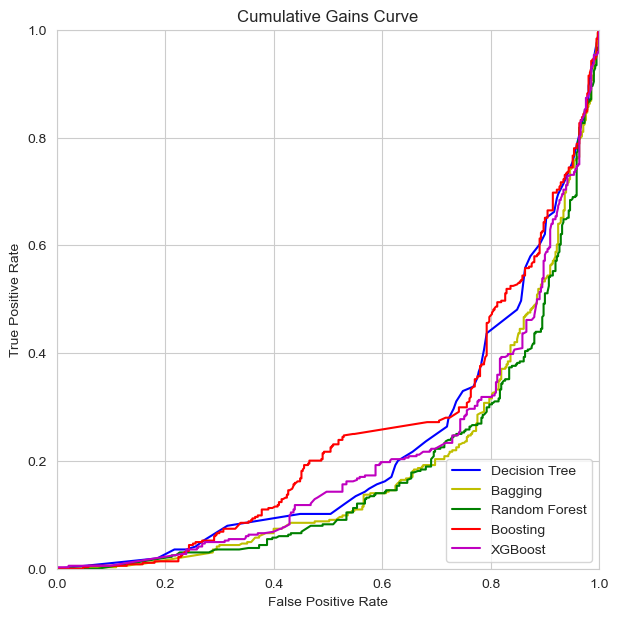

In [24]:
# Plot Cumulative Gains Curve
plt.figure(figsize=(7,7))
plt.title('Cumulative Gains Curve')
plt.plot(tpr_tree, fpr_tree, 'b', label = 'Decision Tree')
plt.plot(tpr_bagging, fpr_bagging, 'y', label = 'Bagging')
plt.plot(tpr_rf, fpr_rf, 'g', label = 'Random Forest')
plt.plot(tpr_boosting, fpr_boosting, 'r', label = 'Boosting')
plt.plot(tpr_xgb, fpr_xgb, 'm', label = 'XGBoost')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
def plot_Lift_curve(models, X_val, y_val, step=0.01):
    
    # Create a figure for the lift curve of 4 models
    fig, ax = plt.subplots(figsize=(15, 5))
    lift_10_percent = {}

    for model in models:
        y_pred = model.predict_proba(X_val)[:, 1]

        # Define an auxiliary dataframe to plot the curve
        aux_lift = pd.DataFrame()
        # Create a real and predicted column for our new DataFrame and assign values
        aux_lift['real'] = y_val
        aux_lift['predicted'] = y_pred
        # Order the values for the predicted probability column:
        aux_lift.sort_values('predicted', ascending=False, inplace=True)

        # Create the values that will go into the X axis of our plot
        x_val = np.arange(step, 1 + step, step)
        # Calculate the ratio of ones in our data
        ratio_ones = aux_lift['real'].sum() / len(aux_lift)
        # Create an empty vector with the values that will go on the Y axis our our plot
        y_v = []

        # Calculate for each x value its correspondent y value
        for x in x_val:
            num_data = int(np.ceil(x * len(aux_lift)))  # The ceil function returns the closest integer bigger than our number
            data_here = aux_lift.iloc[:num_data, :]  # ie. np.ceil(1.4) = 2
            ratio_ones_here = data_here['real'].sum() / len(data_here)
            y_v.append(ratio_ones_here / ratio_ones)

        ax.plot(x_val, y_v, linewidth=3, markersize=5, label=model.__class__.__name__)
        ax.set_xticks(np.arange(0, 1.1, 0.1))
        lift_10_percent[model.__class__.__name__] = y_v[10]

    ax.plot(x_val, np.ones(len(x_val)), 'k-')
    # Add a continuous line to the plot at x=.1
    ax.axvline(x=0.1, color='k', linestyle='--')
    ax.set_xlabel('Proportion of sample')
    ax.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.legend()
    plt.show()
    return lift_10_percent

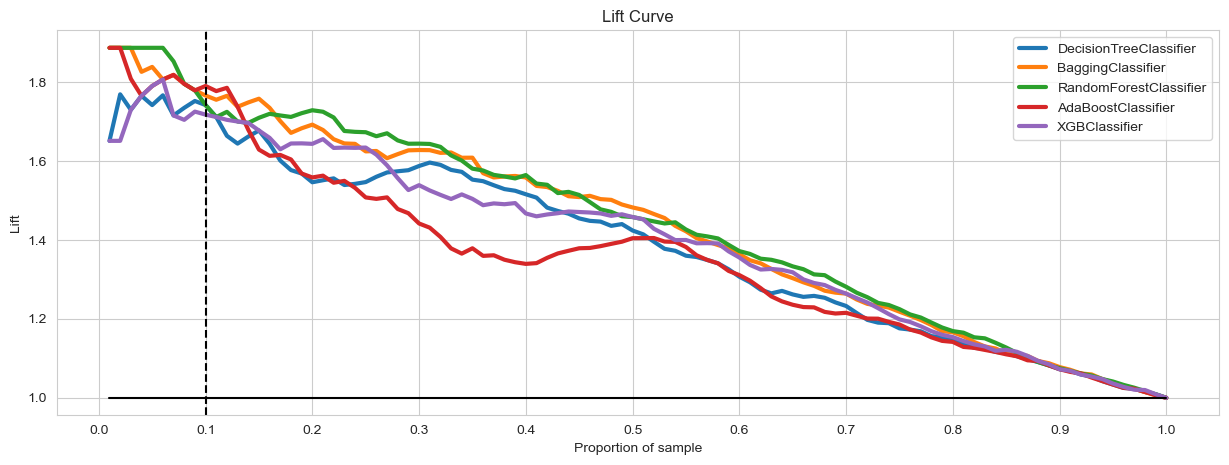

{'DecisionTreeClassifier': 1.7121951219512193,
 'BaggingClassifier': 1.7560975609756098,
 'RandomForestClassifier': 1.7121951219512193,
 'AdaBoostClassifier': 1.778048780487805,
 'XGBClassifier': 1.7121951219512193}

In [28]:
plot_Lift_curve([best_dt, best_bagging, best_rf, best_boosting, xgb_model], X_val, y_val)

>As we can see, the lift for the top 10% of observations in the validation set, the Boosted Tree model has the highest lift. This means that the Boosted Tree model is the best model for this dataset, as it is able to predict the most competitive auctions in the validation set.
>
>It is important to note that the Random Forest model has the highest accuracy, but it is not the best model for this dataset, as it is not able to predict the most competitive auctions in the validation set.

### 1.4

Now, let's move to the last part, how boosted tree, bagged tree and random forest models are conceptually similar and how are they conceptually different. 

>Decision trees are a hierarchical series of checks performed on features to make predictions, and the majority class or average value of a leaf's subset is used as the output. However, these trees are unstable and can produce different results when trained on slightly different training sets. Random forests solve this problem by training multiple trees independently and aggregating their decisions. This method is more robust and accurate, but harder to interpret and takes longer to train.
>
>In contrast, gradient boosting trees also create ensembles, but they are trained sequentially and aim to correct the errors of the previous trees. This approach can capture complex patterns in the data, but it may overfit and model the noise if the data are noisy. Additionally, because of their sequential nature, the output decisions of gradient boosting trees must be evaluated in a fixed order and cannot be parallelized.
>
>The main differences between random forests and gradient boosting trees lie in their training process and output decisions. Random forests train each tree independently and aggregate their predictions, while gradient boosting trees are trained sequentially to correct errors. Random forests can output decisions in any order and aggregate them, while gradient boosting trees must be evaluated in a fixed order.

# 2 Question [32 points]

For each statement write if it is true or false and provide a one sentence explanation. You will get points only if your
explanation is correct.

1. The following plot is the solution path for a Lasso estimate. The two dashed lines correspond to two values of the
tuning parameter λ, and hence two models.

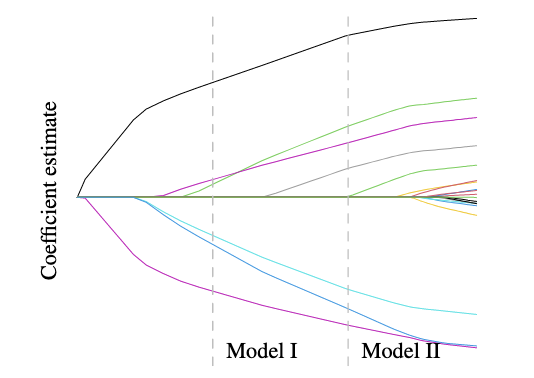

a. Model I uses a larger λ than Model II.

> TRUE, Model I has a higher value of λ than Model II since a higher λ value in Lasso regression leads to greater shrinkage of the coefficients. As a result, some coefficients may shrink to zero, resulting in fewer non-zero coefficients in Model I than in Model II.

b. Model I has a higher variance than Model II.

> FALSE, Model I is considered a simpler model than Model II because it contains fewer non-zero coefficients. Lasso regression achieves this by imposing a penalty on the sum of the absolute values of the coefficients, which causes the coefficient estimates to be shrunk towards zero. As λ increases, the penalty becomes more stringent, leading to a more constrained model with a reduced number of non-zero coefficients. This process mitigates the risk of overfitting and lowers the variance of the model.

c. Model I has a larger in-sample RSS than Model II.

>  TRUE, As λ increases in Lasso regression, the penalty imposed on the model's coefficients becomes more stringent, resulting in a sparser model with fewer non-zero coefficients. This decreases the model complexity by shrinking the coefficient estimates towards zero, leading to a more interpretable model that depends on fewer variables. On the other hand, increasing λ leads to a higher residual sum of squares (RSS) and in-sample loss, which compromises model accuracy. This trade-off between model complexity and accuracy is known as the bias-variance trade-off. With an increasing λ, the bias of the model rises, resulting in a higher RSS.

d. Model I has a larger test error than Model II.

> FALSE, The comparison of the test error between Model I and Model II cannot be made as we do not have access to the test error of either model. However, we can compare the in-sample residual sum of squares (RSS) for each model, which was performed in the previous question.

2. Suppose that we would like to fit a linear model to predict MLB players’ salaries based on their basic information and statistics for the previous season. The following table shows the residual sum of squares for all the onepredictor models.

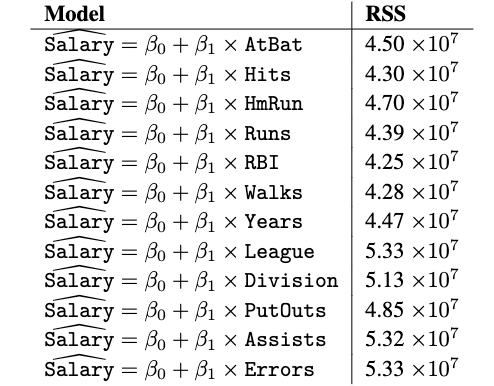

Based on the information given by this table, it is certain that

a. The two-variable model identified by forward stepwise selection includes RBI.

> TRUE, The two-variable model identified by forward stepwise selection includes RBI. The forward stepwise selection method starts with a null model and adds variables one at a time, based on the lowest RSS. The lowest RSS in the table is $4.25*10^7$, which corresponds to the model that includes RBI.

b. The two-variable model identified by forward stepwise selection includes Walks.

> FALSE, with the information given by the table, it is not certain that the two-variable model identified by forward stepwise selection includes Walks, since we need to identify the next best predictor based on lowest error in the two-variable model, with the first variable being RBI. 

c. The two-variable model identified by best subset selection includes RBI.

> FALSE, since we saw in homework 4 that 1-variable model identify by the best subset is the same as the one identifies in forward stepwise selection, which is RBI, but is not necessarily the same for the two-variable model, so RBI might not be included in the two-variable model identified by best subset selection.

d. The two-variable model identified by backward stepwise selection includes RBI

> FALSE, The backward stepwise selection method starts with a full model and removes variables one at a time, based on the lowest RSS, but with the information given it may or may not include RBI.

3. Do the following action increases the bias of the model?
   
a. Increase k, the number of nearest neighbors, in a kNN classifier.

> TRUE, Increasing k, the number of nearest neighbors, in a kNN classifier increases the bias of the model. As the value of k increases, the model becomes less flexible and less sensitive to local variations in the data. This can lead to underfitting, as a result, the model is more likely to make biased predictions.

b. Add interaction terms to a linear regression model.

> FALSE, Adding interaction terms to a linear regression model decreases the bias of the model. Adding interaction terms to a linear regression model can decrease the bias and increase the model's variance, which can lead to overfitting if the model is too complex or the data is noisy.

c. Make more splits when growing a decision tree.

> FALSE, making more splits can decrease the bias and increase the model's variance, which can lead to overfitting if not controlled properly.

d. Increase B, the number of trees in a random forest model.

> FALSE, not necessarily.
> 
> In a random forest model, each tree is grown independently, and the final prediction is the average of the predictions of all the trees. Adding more trees to the model can decrease the variance of the model and improve its ability to generalize to new, unseen data. This is because the predictions of each tree are averaged, and any errors or biases in individual trees tend to cancel out. However, increasing the number of trees can also increase the computational complexity and memory usage of the model.
> 
>Increasing the number of trees in a random forest model can decrease the variance and improve the model's generalization performance, but it may also increase the computational complexity and memory usage of the model.

4. Suppose that we fit a decision tree to predict a person’s height based on gender and age using the following dataset.

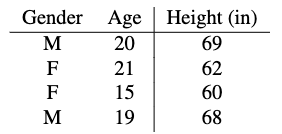

a. The first split is on age.

> FALSE, the first split is on Gender, since the first split is the one that results in the largest reduction in RSS.

b. The second split is on age.

> TRUE, the second split is on age, since the second split is the one that results in the largest reduction in RSS.

c. With two splits, the RSS is smaller than 1.

> TRUE, since the first split is Gender and then age, the side of the Female will have an error of 1 and the other side .25, and the average will be already less than 1 and that's just for the first split, so the RSS will be smaller than 1 with two splits.

d. With three splits, the RSS is 0.

> TRUE, since the split will be done with the exact ages of each person, the RSS will be 0.

In [29]:
# Create a data frame with 3 columns: Gender, age and height
df = pd.read_excel('Tree.xlsx')
df

,Gender,Age,Height
0,M,20,60
1,F,21,69
2,F,15,60
3,M,19,68


Let's just do a sanity check for the decission tree.

RSS (one split): 2.5
RSS (two splits): 0.0
RSS (three splits): 0.0


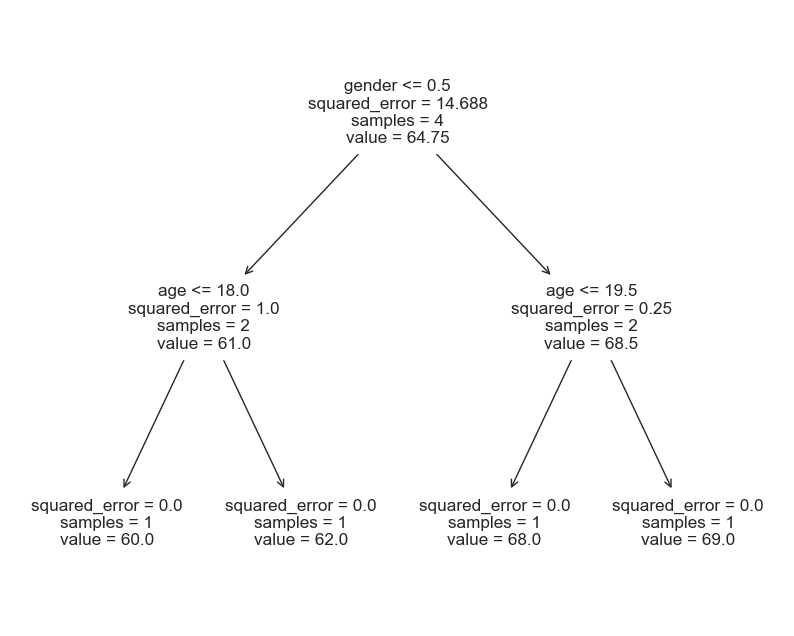

In [30]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Define the data
data = {'height': [69,62,60,68], 'age': [20,21,15,19], 'gender': ['M','F','F','M']}
df = pd.DataFrame(data)

# Convert gender to a binary variable (1 for male, 0 for female)
df['gender'] = pd.get_dummies(df['gender'])['M']

# Define the features and target
X = df[['age', 'gender']]
y = df['height']

# Define the decision tree model with a maximum depth of 3
dt1 = DecisionTreeRegressor(max_depth=1, random_state=0)
dt2 = DecisionTreeRegressor(max_depth=2, random_state=0)
dt3 = DecisionTreeRegressor(max_depth=3, random_state=0)

# Fit the decision tree models and make predictions
dt1.fit(X, y)
dt2.fit(X, y)
dt3.fit(X, y)
y_pred1 = dt1.predict(X)
y_pred2 = dt2.predict(X)
y_pred3 = dt3.predict(X)

# Calculate the RSS at each step
rss1 = ((y - y_pred1) ** 2).sum()
rss2 = ((y - y_pred2) ** 2).sum()
rss3 = ((y - y_pred3) ** 2).sum()

# Print the RSS at each step
print('RSS (one split):', rss1)
print('RSS (two splits):', rss2)
print('RSS (three splits):', rss3)

# Visualize the decision tree
fig, ax = plt.subplots(figsize=(10, 8))
plot_tree(dt3, ax=ax, feature_names=['age', 'gender'])
plt.show()

# 3 Question [30 points]

Your company has hired a consulting firm to help with the fraud problem. You are present in the meeting where the consulting firm presents the results of their pilot study, showing that the model has a very low error rate (percent incorrectly classified instances). They argue to your boss that based on this great performance, she should hire them to build the system. You need to explain to your boss the notions of false positive and false negative errors, and how the system should be evaluated. You may assume that the only relevant decision is (binary): if the system predicts fraud, block the account; if the system predicts no fraud, do nothing.

Explain the following notions:

a) describe the confusion matrix to your boss:

> The confusion matrix is a table that presents the performance of a binary classification model. It shows the number of correct and incorrect predictions made by the model, by comparing its predictions with the actual outcomes in a dataset. The confusion matrix consists of four categories: true positives, false positives, true negatives, and false negatives, like shown in the image below.
>
> 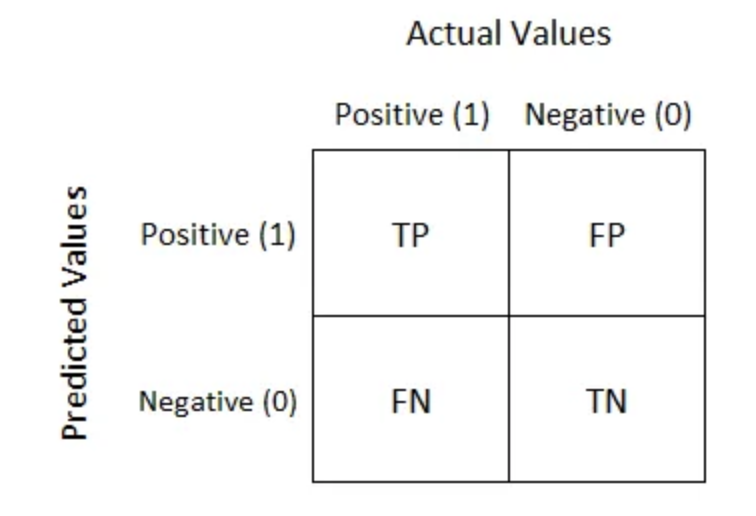
>
> True Positive: You predicted positive and it’s true.
> True Negative: You predicted negative and it’s true.
> False Positive: You predicted positive and it’s false.
> False Negative: You predicted negative and it’s false.

b) describe how you will fill out the confusion matrix for the consultant’s model:

> In this case, the confusion matrix for the consultant's model would have two categories: "fraud predicted" and "fraud not predicted". The consultant's model would predict either "fraud" or "no fraud" for each account. The confusion matrix would then be filled out based on the actual outcome for each account. If the account was fraudulent and the model predicted fraud, it would be a true positive. If the account was not fraudulent and the model predicted fraud, it would be a false positive. If the account was not fraudulent and the model predicted no fraud, it would be a true negative. If the account was fraudulent and the model predicted no fraud, it would be a false negative.

c) describe the cost/benefit matrix for this problem:

> The cost/benefit matrix is a table that presents the costs and benefits associated with the different outcomes in a classification problem. In this case, the cost/benefit matrix would show the financial costs and benefits of correctly and incorrectly classifying an account as fraudulent or not fraudulent. The cost/benefit matrix would help to determine the optimal threshold for the model to use in making its predictions.
> - The True Positive category yields a benefit by preventing losses, as the system accurately identifies fraudulent activity and blocks the associated account.
> - The False Positive category incurs a cost by needlessly blocking an account, as the system mistakenly identifies fraudulent activity and blocks the account.
> - The True Negative category yields a benefit by avoiding unnecessary blocking, as the system correctly identifies no fraudulent activity and allows the account to remain unblocked.
> - The False Negative category incurs a cost by allowing for losses, as the system incorrectly identifies no fraudulent activity and fails to block the associated account.

d) explain briefly why the confusion matrix and the cost/benefit matrix are important for this problem (1-2 sentences):

> The confusion matrix and cost/benefit matrix are important for this problem because they provide a clear understanding of the performance of the model and the financial implications of its decisions. By analyzing the confusion matrix and cost/benefit matrix, we can determine if the model is performing well and if its decisions align with the business objectives.

e) show the proper evaluation function (equation) for the consultant’s model:

> The proper evaluation function for the consultant's model is the F1 score, which is a weighted average of precision and recall. The F1 score is calculated as follows: F1 = 2 * (precision * recall) / (precision + recall), where precision is the number of true positives divided by the sum of true positives and false positives, and recall is the number of true positives divided by the sum of true positives and false negatives.

f) how do the confusion and cost matrices come into play in this function:

> The confusion and cost matrices come into play in the F1 score calculation because they provide the necessary information to calculate precision and recall. Precision is the ratio of true positives to the sum of true positives and false positives, which are both present in the confusion matrix. Recall is the ratio of true positives to the sum of true positives and false negatives, which are also present in the confusion matrix. The cost/benefit matrix provides the financial implications of each of these outcomes, which can be used to determine the optimal threshold for the model to use in making its predictions.

# 4 Question [40 points]

You will use data in marketing.csv for this question. This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test: 1/3 were randomly chosen to receive an e-mail campaign featuring a discount offer; 1/3 were randomly chosen to receive an e-mail campaign featuring a buy one get one free offer; 1/3 were randomly chosen to not receive an e-mail campaign. During a period of two weeks following the e-mail campaign, results were tracked. The first 8 columns provide individual-level data and conversion column is the label that we will try to predict:

- recency: months since last purchase
- history: $value of the historical purchases
- used_discount: indicates if the customer used a discount before
- used_bogo: indicates if the customer used a buy one get one before
- zip_code: class of the zip code as Suburban/Urban/Rural
- is_referral: indicates if the customer was acquired from referral channel
- channel: channels that the customer is using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer

The data were collected through an experiment that allows us to find growth opportunities. Splitting the customers who we are going to send the offer into test (groups receiving one of the two offers) and control groups helps us to calculate incremental gains of offers.

a) Does giving an offer increase conversion? If yes, what kind of offer performs best? Discount or Buy One Get One?

In [31]:
marketing_ = pd.read_csv('marketing.csv')
marketing_

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [32]:
marketing_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


From the table above que can see that there are no nulls in the dataset, and that the data types are correct. The only thing that we need to do is to convert the categorical variables into dummy variables. We will do this using the get_dummies function from pandas.

In [33]:
# Convert into dummy variables: zip and channel 
marketing = pd.get_dummies(marketing_, columns=['zip_code', 'channel'])
marketing

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,Buy One Get One,0,0,1,0,0,1,0
1,6,329.08,1,1,1,No Offer,0,1,0,0,0,0,1
2,7,180.65,0,1,1,Buy One Get One,0,0,1,0,0,0,1
3,9,675.83,1,0,1,Discount,0,1,0,0,0,0,1
4,2,45.34,1,0,0,Buy One Get One,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,Discount,0,0,0,1,0,0,1
63996,5,38.91,0,1,1,Discount,0,0,0,1,0,1,0
63997,6,29.99,1,0,1,Discount,0,0,0,1,0,1,0
63998,1,552.94,1,0,1,Buy One Get One,0,0,1,0,1,0,0


Let's run some basic statistics on the dataset to get a better understanding of the data.

In [34]:
marketing.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781,0.149422,0.449625,0.400953,0.121281,0.437828,0.440891
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890,0.356507,0.497460,0.490095,0.326456,0.496123,0.496498
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now, we are given that the customers were split into three groups: 1/3 were randomly chosen to receive an e-mail campaign featuring a discount offer; 1/3 were randomly chosen to receive an e-mail campaign featuring a buy one get one free offer; 1/3 were randomly chosen to not receive an e-mail campaign. Let's make a plot to visualize this.

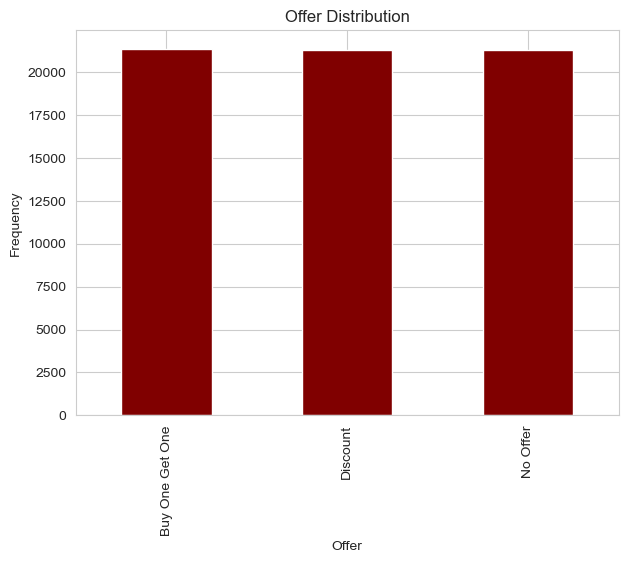

In [35]:
# Plot the distribution of the target variable offer 
marketing['offer'].value_counts().plot(kind='bar', color='maroon', figsize=(7,5))
plt.title('Offer Distribution')
plt.xlabel('Offer')
plt.ylabel('Frequency')
plt.show()

In [36]:
# Create a DataFrame with the conversion rate for each offer
conversion_rate = pd.DataFrame(marketing.groupby('offer')['conversion'].mean())
conversion_rate

,conversion
offer,
Buy One Get One,0.151400
Discount,0.182757
No Offer,0.106167


>From the table above we can see that the conversion rate increases when the customer receives an offer. The conversion rate is higher for the discount offer than for the buy one get one offer, but both offers are better than no offer. 

For the rest of the question, we will focus on the customers who received the Discount offer or did not receive any offer.

b) Partition the data into 60% train and 40% validation set.

c) Build a model for P(conversion = 1 |offer,x), where x denotes the individual-level characteristics. Discuss how you chose the parameters used to build the model. Which one is it? Why did you choose it?

Our interest is not just in how different offers did overall, nor is it whether we can predict the probability that a customer will convert after receiving the offer. Rather our goal is to predict how much (positive) impact the offer will have on a specific customer. That way the marketing campaign can direct its limited resources towards the customers who are the most persuadable—those for whom sending the offer will have the greatest positive effect.

Given the information above we are going to encode our target variable as follows:
- 0: no offer
- 1: discount offer

And we are going to drop the "buy one get one" offer from the dataset.

In [37]:
# Drop the rows with offer = buy one get one and create a column target
df_marketing = marketing[marketing['offer'] != 'Buy One Get One'].reset_index(drop=True)
# Convert offer into a binary variable and drop the original column
df_marketing['offer_'] = np.where(df_marketing['offer'] == 'No Offer', 0, 1)
df_marketing.drop('offer', axis=1, inplace=True)
df_marketing

,recency,history,used_discount,used_bogo,is_referral,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_
0,6,329.08,1,1,1,0,1,0,0,0,0,1,0
1,9,675.83,1,0,1,0,1,0,0,0,0,1,1
2,9,675.07,1,1,1,0,1,0,0,0,1,0,1
3,2,101.64,0,1,0,1,0,0,1,0,0,1,1
4,4,241.42,0,1,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42608,7,86.46,0,1,0,0,0,0,1,0,0,1,1
42609,10,105.54,1,0,0,0,0,0,1,0,0,1,1
42610,5,38.91,0,1,1,0,0,0,1,0,1,0,1
42611,6,29.99,1,0,1,0,0,0,1,0,1,0,1


In [38]:
# Let's partition the data into train(60%) and test sets(40%)
X_m = df_marketing.drop(['conversion'], axis=1)
target, y_m = df_marketing['conversion'], df_marketing['offer_']

X_train, X_test, y_train, y_test = train_test_split(X_m, target, test_size=0.4, random_state=410)
print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (25567, 12)
testing: (17046, 12)


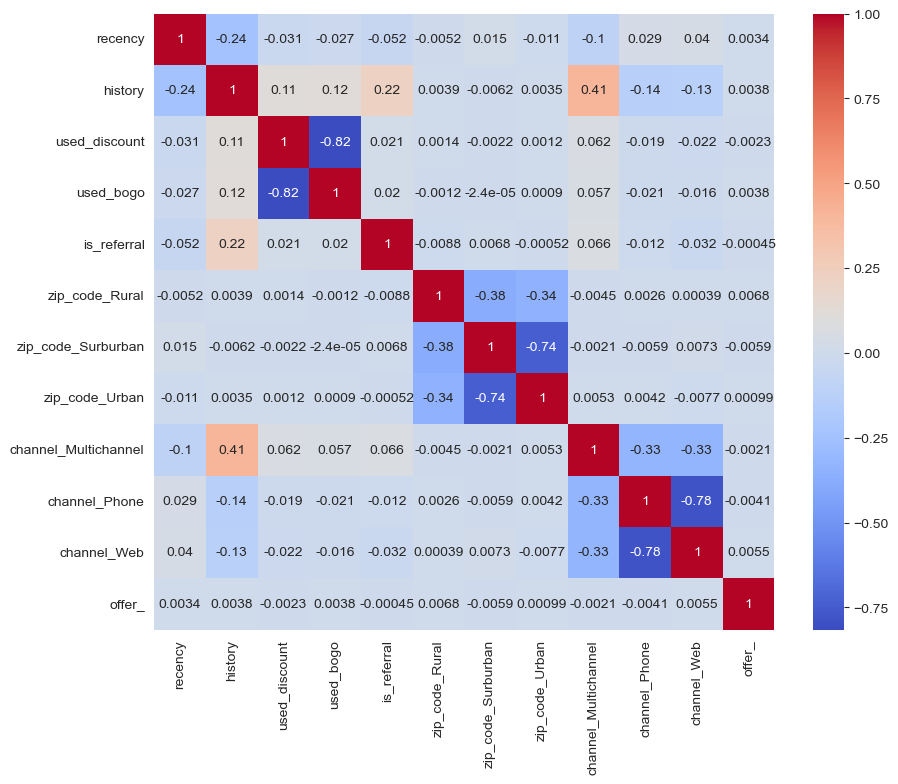

In [39]:
# Let's run a correlation matrix to see the correlation between the features
plt.figure(figsize=(10,8))
sns.heatmap(X_m.corr(), annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix above we can see that there is a strong correlation between the "used_discount" and "used_bogo" variables. This is because a customer can only use one of the offers. Also, there is a positive correlation between multichannel and history, which makes sense because customers who have a higher history are more likely to use more than one channel.

Now, let's create a correlation matrix of y_m and target

In [40]:
# Correlation between y_m and target
y_m.corr(target)

0.10892860449293784

Before doing our feauture selection, let's run a logistic regression model with all the variables.

In [42]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Let's do a grid search to find the best parameters for the logistic regression model
grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(lr_model, grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters are:", grid_search.best_params_)

# Train the model with the best parameters
lr_model = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'], class_weight='balanced')

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = lr_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Best parameters are: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.61


In [43]:
# Import necessary libraries
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
model = LogisticRegression()

# Create cross-validation object
cv = StratifiedKFold(n_splits=5)

# Create feature selection object using RFECV
rfe = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')

# Fit feature selection object to data
rfe.fit(X_m, target)

# Rank variables by their importance
rfe_rank = pd.Series(rfe.ranking_, index = X_m.columns)
rfe_rank.sort_values(ascending=True, inplace=True)
print(rfe_rank)

recency                 1
history                 1
used_discount           1
used_bogo               1
is_referral             1
zip_code_Rural          1
zip_code_Surburban      1
zip_code_Urban          1
channel_Multichannel    1
channel_Phone           1
channel_Web             1
offer_                  1
dtype: int64


From the model above we can see that this model does not really helps for our feature selection. So we will try to run another couple of models to see if we can get a better result.

In [44]:
# Import necessary libraries
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information scores
mi_scores = mutual_info_classif(X_m, target, random_state=410)

# Create pandas Series with variable names as index and mutual information scores as values
mi_scores_series = pd.Series(mi_scores, index=X_m.columns)

# Rank variables by their mutual information scores
mi_rank = mi_scores_series.sort_values(ascending=False)
print(mi_rank)


offer_                  0.009003
used_bogo               0.004722
history                 0.004719
zip_code_Rural          0.004290
used_discount           0.002737
recency                 0.001968
channel_Phone           0.001754
channel_Web             0.001440
is_referral             0.000959
zip_code_Urban          0.000054
zip_code_Surburban      0.000005
channel_Multichannel    0.000000
dtype: float64


From the model above, we generated a score to rank the features. We can see that the offer, used_bogo and history are the most important features. We will use these features to build our model. Also, we will run boruta and take the intersection of the features selected by both models.

In [45]:
# Create a random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Create Boruta feature selection object
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

# Fit Boruta feature selection object to data
boruta_selector.fit(X_m.values, target.values)

# Create list of feature names
feature_names = list(X_m.columns)

# Create pandas Series with variable names as index and whether they were selected by Boruta as values
boruta_rank = pd.Series(boruta_selector.support_, index=feature_names)

# Print variables ranked by Boruta
print(boruta_rank)

recency                  True
history                  True
used_discount            True
used_bogo               False
is_referral              True
zip_code_Rural           True
zip_code_Surburban      False
zip_code_Urban          False
channel_Multichannel    False
channel_Phone            True
channel_Web             False
offer_                   True
dtype: bool


From the results above we are going to keep all the variables but three:
- zip_code_Urban
- zip_code_Suburban
- channel_Multichannel

In [46]:
# Drop zip_code_Urban and zip_code_Suburban and channel_Multichannel
X_m.drop(['zip_code_Urban', 'zip_code_Surburban', 'channel_Multichannel'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_m, target, test_size=0.4, random_state=410)
print(f"training: {X_train.shape}")
print(f"testing: {X_test.shape}")

training: (25567, 9)
testing: (17046, 9)


In [47]:
# Create a logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Let's do a grid search to find the best parameters for the logistic regression model
grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(lr_model, grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters are:", grid_search.best_params_)

# Train the model with the best parameters
lr_model = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'], class_weight='balanced')

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = lr_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Best parameters are: {'C': 1.0, 'penalty': 'l2'}
Accuracy: 0.61


In [48]:
# Let's get the confusion matrix of our logistic regression model
y_pred = lr_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[8903, 5703],
       [ 950, 1490]])

In [49]:
from sklearn.metrics import roc_auc_score

# Let's print the auc score of our logistic regression model
y_pred_proba = lr_model.predict_proba(X_test)[:,1]
print(f'AUC score: {roc_auc_score(y_test, y_pred_proba)}')

AUC score: 0.6568324296325562


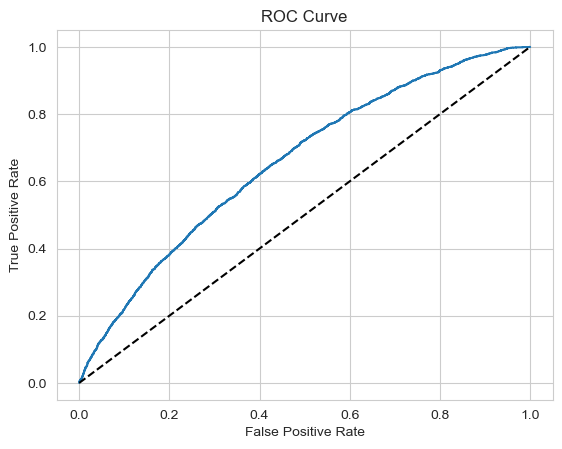

In [50]:
# Let's plot the roc curve of our logistic regression model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The parameter of our model were chosen based on the results of the following:
- Boruta, RFE feature selection and mutual information score
- Grid search for the best parameters, given as a result of the previous feature selection: 
    - C: 0.1
    - penalty: l2 which corresponds to ridge regression
    - NOTE: it is important to mention that we have a class imbalance problem, so we are going to use the class_weight parameter to balance the classes.

The reason why we chose a logistic regression model is because it is a good model for binary classification problems. Also, it is a good model to use when we have a class imbalance problem, which is our case.

Our interest is not just in how different offers did overall, nor is it whether we can predict the probability that a customer will convert after receiving the offer. Rather our goal is to predict how much (positive) impact the offer will have on a specific customer. That way the marketing campaign can direct its limited resources towards the customers who are the most persuadable—those for whom sending the offer will have the greatest positive effect.

d) For each record in the validation set, compute the uplift defined as

$uplift(x) = P(conversion = 1 |offer = Discount,x) −P(conversion = 1 |offer = No Offer,x)$

If a campaign has the resources to target 25% of the customers, what uplift cutoff should be used? If we are to target 25% of the customers in the validation set based on the uplift obtained from your model, how much better would we do compared to random targeting?

Let's create two datasets for our uplift model: one with the customers who received the discount offer and one with the customers who did not receive any offer.

In [51]:
# Probability of conversion=1 given offer_1 = 1 and x 
X_Offer = X_test.copy()
X_Offer['offer_'] = 1

X_WO_Offer = X_test.copy()
X_WO_Offer['offer_'] = 0

# Predict the probability of conversion=1 given offer_1 = 1 and x
p_offer = lr_model.predict_proba(X_Offer)[:,1]
p_wo_offer = lr_model.predict_proba(X_WO_Offer)[:,1]

# Calculate the uplift
uplift = p_offer - p_wo_offer

# Create a dataframe with the uplift values
uplift_df = pd.DataFrame(data = {'uplift': uplift, 'offer_': X_test['offer_'], 'conversion': y_test})
uplift_df

,uplift,offer_,conversion
33584,0.168243,1,0
21927,0.151937,0,0
26236,0.168090,1,0
38330,0.158344,0,0
26911,0.169364,0,1
...,...,...,...
34206,0.119721,0,0
1141,0.162343,0,0
13792,0.148346,0,0
18419,0.169119,0,0


In [52]:
# Create the uplift target 25% of the customers with the highest uplift values
uplift_25 = np.percentile(uplift_df['uplift'], 75)
print(f"Uplift 25%: {uplift_25:.3f}")

Uplift 25%: 0.168


In [53]:
top_25 = uplift_df[uplift_df['uplift'] >= uplift_25]['conversion'].sum()
mean_25 = uplift_df['conversion'].sum()/4
print(f"Uplift of top 25% of population: {top_25}")
print(f"Conversion of 25% of random population: {mean_25}")
print(f"Extra population given our model: {top_25 - mean_25}")

Uplift of top 25% of population: 657
Conversion of 25% of random population: 610.0
Extra population given our model: 47.0


When running the uplift model we could see that we get extra 47 customers who are more likely to convert. This means that we are going to target 47 customers more than if we were to target randomly.

Also, it is important to mention that the Logistic Regression model that we built is not the best model for this problem. We tried to use other models, but we were not able to get a better result. We think that the reason for this is because we have a class imbalance problem, and the models that we tried to use are not good for this kind of problems.